<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_25-26/blob/main/notebooks/Lab-4.Regularizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regularized Linear Regression and $K$-Fold Cross Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from numpy.linalg import inv

Tasks for this lab:

* Generate linearly separable data with different amount of noise;

* Calculate the Least Square Regression (LSR) solution without or with regularization (Ridge, Lasso and Elastic Net);

* Test which of the three methods achieve better test error.

## Data Generation for Regression (cfr Lab 1)


In [2]:
def datagen(d, points, m, M, w, sigma):
    X = np.zeros((points,d))
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    eps = np.random.normal(0, sigma, points)
    y = np.dot(X,w) + eps
    return X, y

In [3]:
# generate multi-dimensional regression dataset
d = 100
w = np.random.normal(0, 1, d)
sigma = 0.1
points = 1000
m = -10
M = 10

X, y = datagen(d, points, m, M, w, sigma)

## Gradient Descent for (Regularized) Linear Regression

Squared error loss and its gradient for **non-regularized linear regression** (cfr Lab 3):


$$
\mathcal{L}=\frac{1}{n}\|y-Xw\|_{2}^{2},\;\;\;\;\nabla_{w} \mathcal{L} = -\frac{2}{n}X(y-Xw)
$$

In [7]:
def SquareLoss(X, y, w, points):
    return (1/points)*LA.norm(y-X@w,2)


def OLSGradient(X, y, w, points):
    return (-2/points)*((y-X@w)@X)


def GD(X, y, iter, gamma, points, d):
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:,i] = w
        w = w - gamma*OLSGradient(X, y, w, points)
        L[i] = SquareLoss(X,y,w,points)
    return W, L

In [8]:
d = np.shape(X)[1]
iter = 1000 #
points = 100
gamma = 0.001 #

wgd, L = GD(X, y, iter, gamma, points, d)

wpred = wgd[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpred,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.005139425031369023


Squared error loss and its gradient for **Ridge regression**:

$$
L=\|y-Xw\|_{2}^{2}+\lambda\|w\|_{2}^{2},\;\;\;\;\nabla_{w} L = -X(y-Xw)+2\lambda w
$$

Ridge Regression performs $L2$ regularization, i.e. it minimizes the penalized sum of squares in such a way that smaller $w$ are preferred, indeed the closer the $w$ are to $0$, the smaller is the loss function.

In [9]:
def RidgeSquareLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L2 penalty term
    """
    return LA.norm(y-X@w,2) + lam*LA.norm(w,2)


def RidgeGradient(w, lam):
    return 2*lam*w

def GDRidge(X, y, iter, gamma, points, d, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    lam : float
        Weight of the L2 penalty term
    """
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    # w = np.random.normal(0,0.1,d)
    w = np.zeros(d)
    for i in range(iter):
        W[:,i] = w
        w = w - gamma * (OLSGradient(X, y, w, points) + RidgeGradient(w, lam))
        L[i] = RidgeSquareLoss(X,y,w,lam)
    return W, L

In [11]:
d = np.shape(X)[1]
iter = 100
points = 100
gamma = 0.0001
lam = 0.1

wgdR, L = GDRidge(X, y, iter, gamma, points, d, lam)
wpredR = wgdR[:,-1]
print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredR,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.11868730358013234


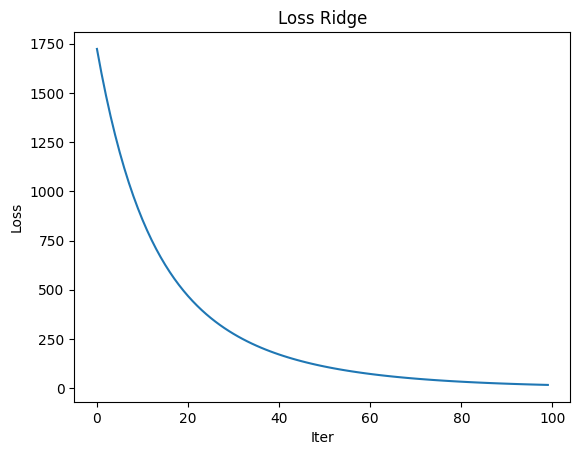

In [13]:
plt.plot(L)
plt.title('Loss Ridge')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

Squared error loss and its gradient for **Lasso (Least Absolute Shrinkage and Selection Operator) regularization**:

$$
L=\|y-Xw\|_{2}^{2}+\lambda\|w\|_{1},\;\;\;\;\nabla_{w} L = pr[-X(y-Xw)]
$$

This kind of regularization can lead to zero the coefficients, i.e. some of the features of the points could be completely neglected, so it can be used and regareded also as a feature selection strategy.

Since we cannot compute the gradient of the penalization term (as it is not differentiable at $0$), we will use **subgradient descent**, that is an algorithm for minimizing a nondifferentialble convex function.

We define the sub-differential of the absolute value function as:

$$
\partial \|w\|_1 = \left\{\begin{matrix}
1 & w>0 \\  
-1 & w<0 \\
[-1, 1] & w=0
\end{matrix}\right.
$$

Hence:

$$
\nabla_{w} L = -\frac{2}{n}\cdot-X(y-Xw))+\lambda \partial \|w\|_1
$$

In [14]:
def LassoSquareLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L1 penalty term
    """
    return LA.norm(y-X@w,2) + lam*LA.norm(w,1)

In [15]:
def L1_subgradient(z):
    g = np.ones(z.shape)
    g[z < 0.] = -1.0
    return g

def LassoGradient(w, lam):
    return lam * L1_subgradient(w)

In [16]:
def GDLasso(X, y, iter, gamma, points, d, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    lam : float
        Weight of the L1 penalty term
    """
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:,i] = w
        w = w - gamma * (OLSGradient(X, y, w, points) + LassoGradient(w, lam))
        L[i] = LassoSquareLoss(X, y, w, lam)
    return W, L

In [17]:
d = np.shape(X)[1]
iter = 1000
points = 100
gamma = 0.001
lam = 0.1

wgdL, L = GDLasso(X, y, iter, gamma, points, d, lam)
wpredL = wgdL[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredL,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.005295066889304967


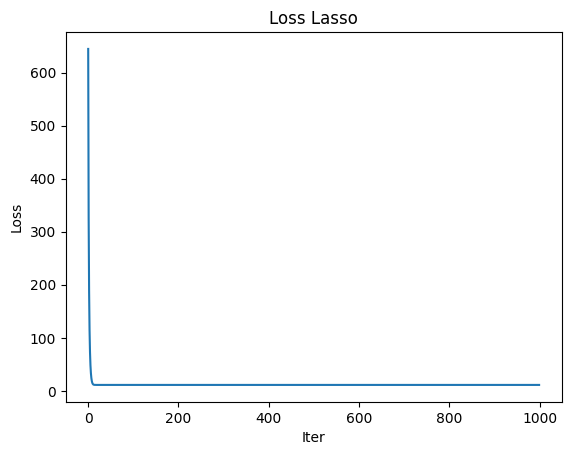

In [18]:
plt.plot(L)
plt.title('Loss Lasso')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## Elastic Net

Regularized regression method that combines the $L1$ and $L2$ penalties of the Lasso and Ridge methods, respectively, to get the best of both words.
The loss function to minimize is defined as:

$$
L=\|y-Xw\|_{2}^{2}+\lambda_1\|w\|_{1} + \lambda_2 \|w\|_2
$$

Hence in this problem we have $2$ parameters to tune.

We can rewrite the problem as follows, so that we have only $1$ parameter $\lambda$ to tune (i.e. as a convex combination of Ridge and Lasso penalties):

$$
L=\|y-Xw\|_{2}^{2}+(\lambda_r) \cdot \lambda\|w\|_{1} + (1 - \lambda_r) \cdot \lambda \|w\|_2
$$

where $\lambda_r$, which is provided in input, is the _importance_ given to the $L1$ penalty (the opposite is also possible).

1. Since the derivative of the sum is the sum of the derivatives, put together all the elements seen so far and implement the GD algorithm for ElasticNet

In [19]:
def ElasticNetSquareLoss(X, y, w, lam1, lam2):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam1 : float
        Weight of the L1 penalty term
    lam2 : float
        Weight of the L2 penalty term
    """
    return LA.norm(y-X@w,2) + lam1*LA.norm(w,1) + lam2*LA.norm(w,2)

In [20]:
def OLSGradient(X, y, w, points):
    return (-2/points)*((y-X@w)@X)

def L1_subgradient(z):
    g = np.ones(z.shape)
    g[z < 0.] = -1.0
    return g

def LassoGradient(w, lam1):
    return lam1 * L1_subgradient(w)
def RidgeGradient(w, lam2):
    return 2*lam2*w




In [21]:
def GDElasticNet(X, y, iter, gamma, points, d, lam1, lam2):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    lam1 : float
        Weight of the L1 penalty term
    lam2 : float
        Weight of the L2 penalty term
    """
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:,i] = w
        w = w - gamma * (OLSGradient(X, y, w, points) + LassoGradient(w, lam1) + RidgeGradient(w, lam2))
        L[i] = ElasticNetSquareLoss(X, y, w, lam1, lam2)
    return W, L

In [22]:
d = np.shape(X)[1]
iter = 1000
points = 100
gamma = 0.001
lam1 = 0.1
lam2 = 0.1

wgdL, L = GDElasticNet(X, y, iter, gamma, points, d, lam1, lam2)
wpredL = wgdL[:,-1]

print('L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights: ', LA.norm(w-wpredL,2))

L2 Norm of the Difference Between Ground Truth Weigths and Predicted Weights:  0.007216578069550198


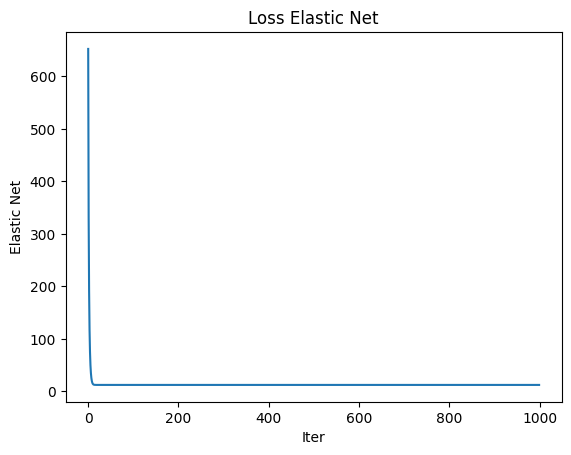

In [23]:
plt.plot(L)
plt.title('Loss Elastic Net')
plt.xlabel('Iter')
plt.ylabel('Elastic Net')
plt.show()

## $K$-fold Cross validation

Resampling algorithm for estimating the _goodness_ of a machine learning algorithm on unseen data.

$K$ is the number of non-overlapping sets we will partition our dataset into. The general procedure is as follows:


1.   Shuffle the dataset randomly;
2.   Split the dataset into $K$ groups of almost equal size;
3. For every group $k\in \{1,\dots, K\}$:
    *   Use group $k$ as validation set;
    *   Use all the other groups as training set;
    * Train and evaluate the model on the above-mentioned sets;
4. Summarize the results of the $K$-validation runs (usually taking the mean).

**Remarks**: every set of data is used $1$ time as validation set and $k-1$ times as part of the training set.

There is a bias-variance trade-off in the choice of the hyperparameter $K$ (usually $K\in \{5, 10\}$ is used): lower $K$ might have more bias, while higher $K$ might have more variance.

We will use $K$-fold CV to tune the parameter $\lambda$ of the Ridge Regression algorithm.

In [ ]:
d = 1
sigma = 3
points = 100
m = -10
M = 10
iter = 500
gamma = 0.001

w = np.random.normal(0, 1, d)

Xtr, ytr = datagen(d, points, m, M, w, sigma) # training dataset
Xts, yts = datagen(d, points, m, M, w, sigma) # test dataset

In [ ]:
def KFoldCVRLS(Xtr, ytr, K, lam):
    """
    Parameters
    ----------
    Xtr : matrix of float of dim n x d
        Dataset
    Ytr : array of float of dim n
        Ground truth values
    K : int
        Number of folds to split the data into
    lam : array of float
        Tuning hyperparameter under analysis
    """
    num_hpar = len(lam) # number of possible values for the hyperparameter
    points = Xtr.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    # array containing the mean and std of the training error for each
    # hyperparameter accross all K runs of CV
    tr_mean = np.zeros(num_hpar)
    val_mean = np.zeros(num_hpar)
    # array containing the mean and std of the validation error for each
    # hyperparameter accross all K runs of CV
    tr_std = np.zeros(num_hpar)
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    # train and validation loss for each of the K runs for each of the
    # possible hyperparameter values
    train_loss = np.zeros((num_hpar,K))
    val_loss = np.zeros((num_hpar,K))

    # loop across all hyperparameters values
    for l_idx, l in enumerate(lam):
        first = 0
        # K-fold CV runs
        for fold in range(K):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points)
            flags[first:first + fold_size] = 1
            # construct the  training and validation set
            X = Xtr[rand_idx[flags==0]]
            y = ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            y_val = ytr[rand_idx[flags==1]]

            # compute the training error of the Ridge regression for the given value of lambda
            W, L = GDRidge(X, y, iter, gamma, points, d, l)
            train_loss[l_idx, fold] = L[-1]

            # compute the validation error of the Ridge regression for the given value of lambda
            val_error = SquareLoss(X_val, y_val, W[:, -1])
            val_loss[l_idx, fold] = val_error

            # update the first position to select the next fold
            first = first + fold_size

        # summarize performance metrics
        tr_mean[l_idx] = np.mean(train_loss[l_idx,:])
        val_mean[l_idx] = np.mean(val_loss[l_idx,:])

        tr_std[l_idx] = np.std(train_loss[l_idx,:])
        val_std[l_idx] = np.std(val_loss[l_idx,:])

    best_par_idx = np.argmin(val_mean)
    best_par = lam[best_par_idx]

    return best_par, val_mean, val_std, tr_mean, tr_std, train_loss, val_loss

In [ ]:
K = 10
lam = np.linspace(0, 1, 11)
print('Lambda is chosen among: ', lam)

best_par, val_mean, val_std, tr_mean, tr_std, t_loss, v_loss = KFoldCVRLS(Xtr, ytr, K, lam)
print('Best lambda: ', best_par)

Lambda is chosen among:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Best lambda:  1.0


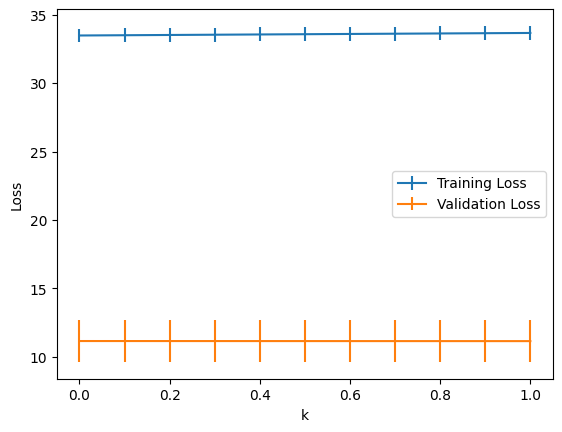

In [ ]:
plt.errorbar(lam, tr_mean, yerr=tr_std, label= 'Training Loss')
plt.errorbar(lam, val_mean, yerr=val_std, label= 'Validation Loss')
plt.xlabel('k')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Additional Resources**



*   [Regularization Part 1: Ridge (L2) Regression](https://youtu.be/Q81RR3yKn30?si=8zRBumzaZ_zLO2Z5)
*   [Regularization Part 2: Lasso (L1) Regression](https://youtu.be/NGf0voTMlcs?si=dYklAVtMtZKU2Vao)
* [Ridge vs Lasso Regression, Visualized](https://www.youtube.com/watch?v=Xm2C_gTAl8c)


**Deep Dive Lab 3**

Learning Rate Schedulers

*   [How to Choose a Learning Rate Scheduler for Neural Networks](https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler)
*   [A (Very Short) Visual Introduction to Learning Rate Schedulers ](https://medium.com/@theom/a-very-short-visual-introduction-to-learning-rate-schedulers-with-code-189eddffdb00)

Recall and metrics for classification


*  [Classification: Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Classification: Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)


